# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ERA2/Session7/models')

In [ ]:
# Auto reload the modules
%load_ext autoreload
%autoreload 2

In [ ]:
from model import Model_5

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 77992236.07it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32783678.98it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20450447.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3279485.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([64, 1, 28, 28])
torch.Size([64])


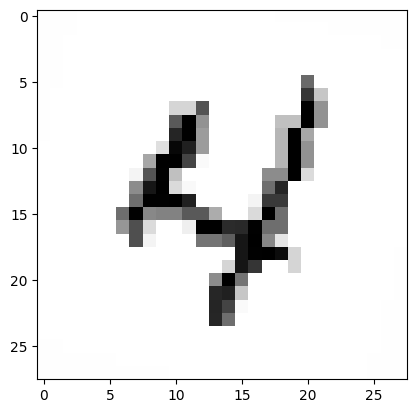

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

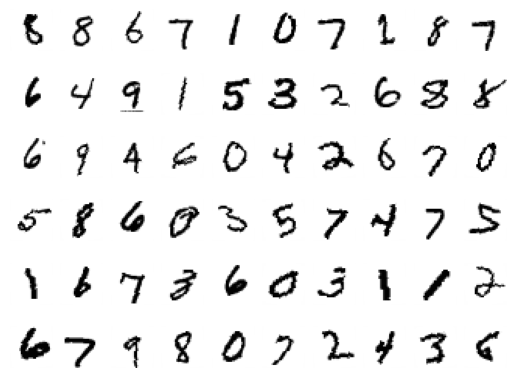

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

## Target
1. Less than 9000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 5%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_5().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
       BatchNorm2d-2           [-1, 12, 28, 28]              24
              ReLU-3           [-1, 12, 28, 28]               0
           Dropout-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 12, 12, 12]           1,296
      BatchNorm2d-11           [-1, 12, 12, 12]              24
             ReLU-12           [-1, 12, 12, 12]               0
          Dropout-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []

def train(model, device, train_loader, optimizer, epoch,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.17062175273895264 Batch_id=937 Accuracy=87.44: 100%|██████████| 938/938 [01:26<00:00, 10.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1761: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [0.01523497150347064]

Test set: Average loss: 0.0585, Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.013440027832984924 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [01:22<00:00, 11.40it/s]


Epoch: 1 LR: [0.0436805283187243]

Test set: Average loss: 0.0495, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.011401884257793427 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [01:23<00:00, 11.27it/s]


Epoch: 2 LR: [0.0760206279366056]

Test set: Average loss: 0.0306, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.011829713359475136 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


Epoch: 3 LR: [0.09711609962268548]

Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


Loss=0.058217354118824005 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [01:22<00:00, 11.33it/s]


Epoch: 4 LR: [0.09943916399561717]

Test set: Average loss: 0.0255, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.04841256141662598 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


Epoch: 5 LR: [0.09504154101677577]

Test set: Average loss: 0.0289, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.08928163349628448 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]


Epoch: 6 LR: [0.08664179722792444]

Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.030561137944459915 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:21<00:00, 11.55it/s]


Epoch: 7 LR: [0.07498628672637109]

Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.0026030263397842646 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]


Epoch: 8 LR: [0.061110652769544124]

Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.0049413698725402355 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [01:21<00:00, 11.55it/s]


Epoch: 9 LR: [0.046247806326724254]

Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.02343447133898735 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:20<00:00, 11.68it/s]


Epoch: 10 LR: [0.03171837652888333]

Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


Loss=0.011960679665207863 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]


Epoch: 11 LR: [0.018813366974912007]

Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.011525171808898449 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [01:21<00:00, 11.57it/s]


Epoch: 12 LR: [0.008679444396382234]

Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.00202154740691185 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:20<00:00, 11.67it/s]


Epoch: 13 LR: [0.0022170522863831426]

Test set: Average loss: 0.0151, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.05094844847917557 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


Epoch: 14 LR: [4.0254362882487444e-07]

Test set: Average loss: 0.0150, Accuracy: 9957/10000 (99.57%)

